In [1]:
# Install required packages
!pip install pandas numpy matplotlib seaborn scikit-learn xgboost openpyxl tensorflow keras -q

print("All packages installed successfully!")

All packages installed successfully!


In [2]:
# Data manipulation
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# ML libraries
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import xgboost as xgb

# Deep Learning libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Bidirectional, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Warnings
import warnings
warnings.filterwarnings('ignore')

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
plt.style.use('seaborn-v0_8-darkgrid')

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

print("Libraries imported successfully!")
print(f"TensorFlow version: {tf.__version__}")

Libraries imported successfully!
TensorFlow version: 2.20.0


In [3]:
# Load the dataset
df = pd.read_excel('soya_data_cleaned_2023_onwards.xlsx')

# Convert date columns
date_columns = ['sales_order_creation_date', 'promised_expedition_date', 'actual_expedition_date', 'date_and_time_expedition']
for col in date_columns:
    if col in df.columns:
        df[col] = pd.to_datetime(df[col], errors='coerce')

print(f"Dataset shape before combining batches: {df.shape}")
print(f"Date range: {df['actual_expedition_date'].min()} to {df['actual_expedition_date'].max()}")

# Combine orders with same client_order_number (delivered in batches)
print(f"\nTotal records before combining batches: {len(df)}")
print(f"Unique client_order_numbers: {df['client_order_number'].nunique()}")

# Check for duplicates
duplicates = df['client_order_number'].duplicated().sum()
print(f"Orders delivered in multiple batches: {duplicates}")

# Group by client_order_number and aggregate:
# - actual_expedition_date: take the LAST date (max) - when final batch was delivered
# - total_amount_delivered_tm: SUM all batches
# - other fields: take first (they should be the same for the same order)
agg_dict = {
    'sales_order_creation_date': 'first',
    'actual_expedition_date': 'max',  # Last delivery date
    'total_amount_delivered_tm': 'sum',  # Sum all batches
    'client_name': 'first',
}

# Add any other columns that exist in the dataframe
for col in df.columns:
    if col not in agg_dict and col != 'client_order_number':
        agg_dict[col] = 'first'

df = df.groupby('client_order_number', as_index=False).agg(agg_dict)

print(f"After combining batches: {len(df)} unique orders")
print()

df.head()

Dataset shape before combining batches: (15297, 25)
Date range: 2023-01-04 15:37:01 to 2025-09-16 00:00:00

Total records before combining batches: 15297
Unique client_order_numbers: 6887
Orders delivered in multiple batches: 8410
After combining batches: 6887 unique orders



,client_order_number,sales_order_creation_date,actual_expedition_date,total_amount_delivered_tm,client_name,expedition_number,product_name,postal_code_client,city_client,country_client,promised_expedition_date,date_and_time_expedition,contract_number,\ntotal_ordered_converted,total_amount_ordered_tm,city_of_delivery,inventory_tag,inventory_location,total_ordered_converted,purchasing_order_number,trucking_company_name,bill_number,cost_of_purchased_order,quantity_of_purchase_order,year
0,SO-11118,2023-01-03,2023-01-04 15:37:01,2.26,MEUNERIE MARIO BERARD INC,231352.0,Huile de Soya,J0E 1E0,ANGE-GARDIEN,canada,2023-01-03,NaT,None,NaN,3.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2023
1,SO-11119,2023-01-03,2023-01-05 09:16:47,5.07,FERME QUIKO INC,231353.0,Trituro Laitier - Régulier,J0J 1Y0,SAINT-IGNACE-DE-STANBRIDGE,canada,2023-01-05,NaT,None,NaN,5.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2023
2,SO-11120,2023-01-03,2023-01-06 12:03:53,7.72,LES MOULEES BELLIFRANCE,231356.0,Trituro Laitier - Régulier,J2R 1E9,SAINT-HYACINTHE,canada,2023-01-06,NaT,None,NaN,3.10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2023
3,SO-11121,2023-01-03,2023-01-05 07:39:39,3.15,SOLLIO AGRICULTURE S.E.C.,231355.0,Trituro Laitier - Régulier,G6E 0L9,Sainte-Marie,canada,2023-01-05,NaT,None,NaN,3.15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2023
4,SO-11122,2023-01-03,2023-01-05 16:21:49,1.80,MACEWEN AGRICENTRE INC,231357.0,Huile de Soya,K0C 1T0,MAXVILLE,canada,2023-01-04,NaT,None,NaN,4.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2023


In [4]:
# Create order size categories
df['order_size_category'] = pd.cut(
    df['total_amount_delivered_tm'],
    bins=[0, 5, 10, 20, np.inf],
    labels=['Small', 'Medium', 'Large', 'Extra Large'],
    include_lowest=True
)

print("Order Size Distribution:")
print(df['order_size_category'].value_counts())
print(f"\nPercentage:")
print(df['order_size_category'].value_counts(normalize=True) * 100)

Order Size Distribution:
order_size_category
Extra Large    2984
Medium         1477
Small          1285
Large          1141
Name: count, dtype: int64

Percentage:
order_size_category
Extra Large    43.328009
Medium         21.446203
Small          18.658342
Large          16.567446
Name: proportion, dtype: float64


In [5]:
# Filter for Small and Medium orders only
df_filtered = df[df['order_size_category'].isin(['Small'])].copy()

print(f"Original dataset: {len(df)} records")
print(f"Filtered dataset (Small): {len(df_filtered)} records")
print(f"\nCategory breakdown:")
print(df_filtered['order_size_category'].value_counts())

Original dataset: 6887 records
Filtered dataset (Small): 1285 records

Category breakdown:
order_size_category
Small          1285
Medium            0
Large             0
Extra Large       0
Name: count, dtype: int64


In [6]:
# Sort by client and date
df_filtered = df_filtered.sort_values(['client_name', 'sales_order_creation_date'])

# Calculate days since last order for each client
df_filtered['days_since_last_order'] = df_filtered.groupby('client_name')['sales_order_creation_date'].diff().dt.days

# Create next order date (target variable)
df_filtered['next_order_date'] = df_filtered.groupby('client_name')['sales_order_creation_date'].shift(-1)
df_filtered['days_until_next_order'] = (df_filtered['next_order_date'] - df_filtered['sales_order_creation_date']).dt.days

print("Days until next order - Statistics:")
print(df_filtered['days_until_next_order'].describe())



Days until next order - Statistics:
count    1154.000000
mean       39.007799
std       101.329338
min         0.000000
25%         3.000000
50%        13.000000
75%        32.000000
max       847.000000
Name: days_until_next_order, dtype: float64


In [7]:
print("="*80)
print("ENHANCED FEATURE ENGINEERING - CLIENT-LEVEL FEATURES")
print("="*80)

# ============================================================================
# CLIENT-LEVEL FEATURES (Aggregated across all historical orders)
# ============================================================================

client_features = df_filtered.groupby('client_name').agg({
    'total_amount_delivered_tm': ['mean', 'std', 'min', 'max', 'count', 'sum'],
    'days_since_last_order': ['mean', 'std', 'median', 'min', 'max'],
    'sales_order_creation_date': ['min', 'max']
}).reset_index()

client_features.columns = ['_'.join(col).strip('_') for col in client_features.columns.values]
client_features.rename(columns={'client_name': 'client_name'}, inplace=True)

# ============================================================================
# 1. CUSTOMER LIFETIME VALUE (CLV) FEATURES
# ============================================================================
print("\n1. Computing Customer Lifetime Value (CLV) features...")

# Total revenue from client
client_features['total_revenue'] = client_features['total_amount_delivered_tm_sum']

# Calculate client lifetime (days active)
client_features['client_lifetime_days'] = (
    client_features['sales_order_creation_date_max'] - client_features['sales_order_creation_date_min']
).dt.days

# Average revenue per order
client_features['avg_revenue_per_order'] = (
    client_features['total_revenue'] / client_features['total_amount_delivered_tm_count']
)

# Revenue per day (CLV rate)
client_features['revenue_per_day'] = (
    client_features['total_revenue'] / (client_features['client_lifetime_days'] + 1)
)

# Order frequency metrics
client_features['order_frequency_per_month'] = (
    client_features['total_amount_delivered_tm_count'] / 
    ((client_features['client_lifetime_days'] + 1) / 30)
)

# Predicted annual value (if pattern continues)
client_features['predicted_annual_value'] = client_features['revenue_per_day'] * 365

# Client value category (quintiles)
client_features['client_value_tier'] = pd.qcut(
    client_features['total_revenue'], 
    q=5, 
    labels=[0, 1, 2, 3, 4],  # 0=lowest, 4=highest
    duplicates='drop'
).astype(float).fillna(2)  # Default to middle tier

print(f"   ✅ CLV features created: total_revenue, revenue_per_day, client_value_tier")

# ============================================================================
# 2. CLIENT CONSISTENCY & RELIABILITY METRICS
# ============================================================================
print("\n2. Computing client consistency metrics...")

# Ordering consistency (coefficient of variation)
client_features['ordering_consistency_score'] = (
    client_features['days_since_last_order_mean'] / 
    (client_features['days_since_last_order_std'] + 1)
)

# Order size consistency
client_features['order_size_consistency'] = (
    client_features['total_amount_delivered_tm_mean'] / 
    (client_features['total_amount_delivered_tm_std'] + 1)
)

# Client maturity level (based on order count)
client_features['client_maturity'] = pd.cut(
    client_features['total_amount_delivered_tm_count'],
    bins=[0, 5, 15, 30, np.inf],
    labels=[0, 1, 2, 3]  # 0=new, 1=growing, 2=established, 3=veteran
).astype(int)

# High frequency flag
median_freq = client_features['order_frequency_per_month'].median()
client_features['is_high_frequency_client'] = (
    client_features['order_frequency_per_month'] > median_freq
).astype(int)

print(f"   ✅ Consistency features created: ordering_consistency_score, client_maturity")

# ============================================================================
# 3. CLIENT CLUSTERING FEATURES (Similar Clients)
# ============================================================================
print("\n3. Computing client clustering features...")

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# Select features for clustering
clustering_features = [
    'order_frequency_per_month',
    'avg_revenue_per_order',
    'ordering_consistency_score',
    'client_lifetime_days'
]

# Prepare clustering data
cluster_data = client_features[clustering_features].fillna(0)
cluster_data = cluster_data.replace([np.inf, -np.inf], 0)

# Standardize for clustering
scaler_cluster = StandardScaler()
cluster_data_scaled = scaler_cluster.fit_transform(cluster_data)

# K-Means clustering (5 client segments)
n_clusters = min(5, len(client_features) // 10)  # At least 10 clients per cluster
if n_clusters >= 2:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    client_features['client_cluster'] = kmeans.fit_predict(cluster_data_scaled)
    
    print(f"   ✅ Created {n_clusters} client clusters based on behavior patterns")
    print(f"      Cluster distribution: {client_features['client_cluster'].value_counts().to_dict()}")
else:
    client_features['client_cluster'] = 0
    print(f"   ⚠️  Too few clients for clustering, assigning all to cluster 0")

# Calculate cluster-level statistics for similarity features
cluster_stats = client_features.groupby('client_cluster').agg({
    'order_frequency_per_month': 'mean',
    'avg_revenue_per_order': 'mean',
    'days_since_last_order_mean': 'mean'
}).reset_index()

cluster_stats.columns = ['client_cluster', 'cluster_avg_frequency', 
                         'cluster_avg_revenue', 'cluster_avg_reorder_days']

client_features = client_features.merge(cluster_stats, on='client_cluster', how='left')

print(f"   ✅ Cluster statistics added: cluster_avg_frequency, cluster_avg_revenue")

print("\n✅ Client-level features complete!")
print(f"   Total client features: {len(client_features.columns)}")
print(f"\nSample client features:")
print(client_features[['client_name', 'total_revenue', 'client_value_tier', 
                        'client_maturity', 'client_cluster']].head())

ENHANCED FEATURE ENGINEERING - CLIENT-LEVEL FEATURES

1. Computing Customer Lifetime Value (CLV) features...
   ✅ CLV features created: total_revenue, revenue_per_day, client_value_tier

2. Computing client consistency metrics...
   ✅ Consistency features created: ordering_consistency_score, client_maturity

3. Computing client clustering features...
   ✅ Created 5 client clusters based on behavior patterns
      Cluster distribution: {2: 57, 1: 39, 3: 17, 0: 16, 4: 2}
   ✅ Cluster statistics added: cluster_avg_frequency, cluster_avg_revenue

✅ Client-level features complete!
   Total client features: 29

Sample client features:
                             client_name  total_revenue  client_value_tier  \
0    9252-8405 Quebec INC (FERME TRUDEL)           4.97                1.0   
1  9377-8454 QUÉBEC INC/ LASHOP AGRICOLE           1.00                0.0   
2                        AGRI ST-LAURENT          27.55                3.0   
3                        AGRI-MARCHE INC          8

In [9]:
print("\n" + "="*80)
print("ENHANCED FEATURE ENGINEERING - ORDER-LEVEL FEATURES")
print("="*80)

# ============================================================================
# ORDER-LEVEL FEATURES (Row-by-row features for each order)
# ============================================================================
df_features = df_filtered.copy()

# ============================================================================
# 1. BASIC TEMPORAL FEATURES
# ============================================================================
print("\n1. Creating basic temporal features...")

df_features['order_month'] = df_features['sales_order_creation_date'].dt.month
df_features['order_quarter'] = df_features['sales_order_creation_date'].dt.quarter
df_features['order_day_of_week'] = df_features['sales_order_creation_date'].dt.dayofweek
df_features['order_day_of_month'] = df_features['sales_order_creation_date'].dt.day
df_features['is_weekend'] = df_features['order_day_of_week'].isin([5, 6]).astype(int)
df_features['order_sequence'] = df_features.groupby('client_name').cumcount() + 1

print(f"   ✅ Basic temporal features created")

# ============================================================================
# 2. ORDER SEASONALITY PATTERNS
# ============================================================================
print("\n2. Creating seasonality pattern features...")

# Cyclical encoding for time features (better for ML models)
df_features['month_sin'] = np.sin(2 * np.pi * df_features['order_month'] / 12)
df_features['month_cos'] = np.cos(2 * np.pi * df_features['order_month'] / 12)
df_features['day_of_week_sin'] = np.sin(2 * np.pi * df_features['order_day_of_week'] / 7)
df_features['day_of_week_cos'] = np.cos(2 * np.pi * df_features['order_day_of_week'] / 7)

# Season indicator
df_features['season'] = df_features['order_month'].map({
    12: 0, 1: 0, 2: 0,     # Winter
    3: 1, 4: 1, 5: 1,      # Spring
    6: 2, 7: 2, 8: 2,      # Summer
    9: 3, 10: 3, 11: 3     # Fall
})

# Is month-end (last week of month - often different ordering patterns)
df_features['is_month_end'] = (df_features['order_day_of_month'] >= 24).astype(int)

# Is quarter-end
df_features['is_quarter_end'] = df_features['order_month'].isin([3, 6, 9, 12]).astype(int)

# Holiday proximity (approximate major holidays)
# Add your specific region's holidays if needed
df_features['is_near_holiday'] = df_features['order_month'].isin([11, 12, 1]).astype(int)

print(f"   ✅ Seasonality features: cyclical encodings, season, month_end, quarter_end")

# ============================================================================
# 3. PRODUCT CATEGORY INTERACTIONS
# ============================================================================
print("\n3. Creating product category interaction features...")

# Product encoding
df_features['product_encoded'] = LabelEncoder().fit_transform(
    df_features['product_name'].fillna('Unknown')
)

# Product frequency per client (how often they order this product)
df_features['product_client_frequency'] = df_features.groupby(
    ['client_name', 'product_name']
)['product_name'].transform('count')

# Product quantity statistics per client
df_features['product_client_avg_quantity'] = df_features.groupby(
    ['client_name', 'product_name']
)['total_amount_delivered_tm'].transform('mean')

# Product switching indicator (did client change product from last order?)
df_features['product_switched'] = (
    df_features.groupby('client_name')['product_name'].transform(
        lambda x: (x != x.shift(1)).astype(int)
    )
)

# Product popularity (how many clients order this product)
product_popularity = df_features.groupby('product_name')['client_name'].nunique()
df_features['product_popularity_score'] = df_features['product_name'].map(product_popularity)

# Client's product diversity (how many different products they've ordered up to this point)
def expanding_nunique(series):
    """Calculate cumulative unique count"""
    unique_counts = []
    seen = set()
    for val in series:
        seen.add(val)
        unique_counts.append(len(seen))
    return pd.Series(unique_counts, index=series.index)

df_features['client_product_diversity'] = df_features.groupby('client_name')['product_name'].transform(
    expanding_nunique
)

print(f"   ✅ Product interaction features: frequency, switching, popularity, diversity")

# ============================================================================
# 4. ENHANCED ROLLING WINDOW FEATURES (Multiple Horizons)
# ============================================================================
print("\n4. Creating multi-horizon rolling window features...")

# Multiple rolling windows for better pattern capture
for window in [3, 5, 7]:
    # Days between orders
    df_features[f'rolling_avg_days_{window}'] = df_features.groupby('client_name')[
        'days_since_last_order'
    ].transform(lambda x: x.rolling(window=window, min_periods=1).mean())
    
    df_features[f'rolling_std_days_{window}'] = df_features.groupby('client_name')[
        'days_since_last_order'
    ].transform(lambda x: x.rolling(window=window, min_periods=1).std()).fillna(0)
    
    # Order quantities
    df_features[f'rolling_avg_quantity_{window}'] = df_features.groupby('client_name')[
        'total_amount_delivered_tm'
    ].transform(lambda x: x.rolling(window=window, min_periods=1).mean())
    
    df_features[f'rolling_std_quantity_{window}'] = df_features.groupby('client_name')[
        'total_amount_delivered_tm'
    ].transform(lambda x: x.rolling(window=window, min_periods=1).std()).fillna(0)

print(f"   ✅ Rolling features created for windows: 3, 5, 7 orders")

# ============================================================================
# 5. EXPANDING WINDOW FEATURES (Historical statistics)
# ============================================================================
print("\n5. Creating expanding window (historical) features...")

# Historical averages that expand with each order
df_features['days_since_last_order_expanding_mean'] = df_features.groupby('client_name')[
    'days_since_last_order'
].transform(lambda x: x.expanding().mean())

df_features['days_since_last_order_expanding_std'] = df_features.groupby('client_name')[
    'days_since_last_order'
].transform(lambda x: x.expanding().std()).fillna(0)

df_features['quantity_expanding_mean'] = df_features.groupby('client_name')[
    'total_amount_delivered_tm'
].transform(lambda x: x.expanding().mean())

df_features['quantity_expanding_std'] = df_features.groupby('client_name')[
    'total_amount_delivered_tm'
].transform(lambda x: x.expanding().std()).fillna(0)

print(f"   ✅ Expanding window features created")

# ============================================================================
# 6. TREND & MOMENTUM FEATURES
# ============================================================================
print("\n6. Creating trend and momentum features...")

# Order frequency trend
df_features['order_frequency_trend'] = df_features.groupby('client_name')[
    'days_since_last_order'
].transform(lambda x: x.diff())

# Quantity trend
df_features['quantity_trend'] = df_features.groupby('client_name')[
    'total_amount_delivered_tm'
].transform(lambda x: x.diff())

# Recent vs historical comparison (acceleration/deceleration)
df_features['recent_vs_historical_frequency'] = (
    df_features['rolling_avg_days_3'] / 
    (df_features['days_since_last_order_expanding_mean'] + 1)
)

df_features['recent_vs_historical_quantity'] = (
    df_features['rolling_avg_quantity_3'] / 
    (df_features['quantity_expanding_mean'] + 1)
)

# Is ordering accelerating? (gaps getting shorter)
df_features['is_frequency_increasing'] = (
    df_features['order_frequency_trend'] < 0
).astype(int)

print(f"   ✅ Trend features: frequency_trend, quantity_trend, acceleration indicators")

# ============================================================================
# 7. TIME-SINCE-LAST-CONTACT FEATURES
# ============================================================================
print("\n7. Creating time-since-last-contact features...")

# Recency from current date (how long since this order)
current_date = df_features['sales_order_creation_date'].max()
df_features['recency_days'] = (current_date - df_features['sales_order_creation_date']).dt.days

# Time since last order (already have this, but add context)
df_features['days_since_last_order_filled'] = df_features['days_since_last_order'].fillna(0)

# Deviation from client's normal reorder time
df_features['days_deviation_from_mean'] = (
    df_features['days_since_last_order'] - df_features['days_since_last_order_expanding_mean']
).fillna(0)

# Is this order overdue? (took longer than usual)
df_features['is_overdue_order'] = (
    df_features['days_deviation_from_mean'] > df_features['days_since_last_order_expanding_std']
).astype(int)

# Time since first order (client age at this order)
first_order_date = df_features.groupby('client_name')['sales_order_creation_date'].transform('min')
df_features['days_since_first_order'] = (
    df_features['sales_order_creation_date'] - first_order_date
).dt.days

print(f"   ✅ Time-since-last-contact features: recency, deviation, overdue indicator")

# ============================================================================
# 8. CLIENT BEHAVIOR AT ORDER TIME
# ============================================================================
print("\n8. Creating client behavior snapshot features...")

# Client's order count at this point in time
df_features['client_order_count_at_time'] = df_features.groupby('client_name').cumcount() + 1

# Client lifetime at this order
df_features['client_lifetime_at_order'] = df_features['days_since_first_order']

# Order frequency at this point
df_features['order_frequency_at_time'] = (
    df_features['client_order_count_at_time'] / 
    ((df_features['client_lifetime_at_order'] + 1) / 30)
)

print(f"   ✅ Behavioral snapshot features created")

print("\n✅ Order-level feature engineering complete!")
print(f"   Total features: {df_features.shape[1]}")
print(f"\nSample enhanced features:")
print(df_features[['client_name', 'order_sequence', 'season', 'product_switched', 
                    'rolling_avg_days_3', 'is_overdue_order', 'days_until_next_order']].head(10))


ENHANCED FEATURE ENGINEERING - ORDER-LEVEL FEATURES

1. Creating basic temporal features...
   ✅ Basic temporal features created

2. Creating seasonality pattern features...
   ✅ Seasonality features: cyclical encodings, season, month_end, quarter_end

3. Creating product category interaction features...
   ✅ Product interaction features: frequency, switching, popularity, diversity

4. Creating multi-horizon rolling window features...
   ✅ Rolling features created for windows: 3, 5, 7 orders

5. Creating expanding window (historical) features...
   ✅ Expanding window features created

6. Creating trend and momentum features...
   ✅ Trend features: frequency_trend, quantity_trend, acceleration indicators

7. Creating time-since-last-contact features...
   ✅ Time-since-last-contact features: recency, deviation, overdue indicator

8. Creating client behavior snapshot features...
   ✅ Behavioral snapshot features created

✅ Order-level feature engineering complete!
   Total features: 78



In [10]:
# Merge client-level features
df_features = df_features.merge(client_features, on='client_name', how='left')

print(f"Dataset shape after merging: {df_features.shape}")
print(f"\nColumns: {df_features.columns.tolist()}")

Dataset shape after merging: (1285, 106)

Columns: ['client_order_number', 'sales_order_creation_date', 'actual_expedition_date', 'total_amount_delivered_tm', 'client_name', 'expedition_number', 'product_name', 'postal_code_client', 'city_client', 'country_client', 'promised_expedition_date', 'date_and_time_expedition', 'contract_number', '\ntotal_ordered_converted', 'total_amount_ordered_tm', 'city_of_delivery', 'inventory_tag', 'inventory_location', 'total_ordered_converted', 'purchasing_order_number', 'trucking_company_name', 'bill_number', 'cost_of_purchased_order', 'quantity_of_purchase_order', 'year', 'order_size_category', 'days_since_last_order', 'next_order_date', 'days_until_next_order', 'order_month', 'order_quarter', 'order_day_of_week', 'order_day_of_month', 'is_weekend', 'order_sequence', 'month_sin', 'month_cos', 'day_of_week_sin', 'day_of_week_cos', 'season', 'is_month_end', 'is_quarter_end', 'is_near_holiday', 'product_encoded', 'product_client_frequency', 'product_cli

In [11]:
# Remove rows where we don't have a next order (last order for each client)
df_model = df_features[df_features['days_until_next_order'].notna()].copy()

# Remove outliers (optional - orders with extremely long reorder times)
# Keep reorder times within  (e.g., < 30 days)
df_model = df_model[df_model['days_until_next_order'] <= 30]

print(f"Modeling dataset size: {len(df_model)} records")
print(f"Target variable (days_until_next_order) statistics:")
print(df_model['days_until_next_order'].describe())

Modeling dataset size: 851 records
Target variable (days_until_next_order) statistics:
count    851.000000
mean       9.312573
std        9.131900
min        0.000000
25%        1.000000
50%        7.000000
75%       15.000000
max       30.000000
Name: days_until_next_order, dtype: float64


In [12]:
print("="*80)
print("ENHANCED FEATURE SELECTION FOR MODELING")
print("="*80)

# ============================================================================
# SELECT ENHANCED FEATURES FOR MODELING
# ============================================================================

feature_columns = [
    # ========================================================================
    # CORE TEMPORAL FEATURES (Highest importance from bilstm_optimized)
    # ========================================================================
    'days_since_last_order',
    'days_since_last_order_mean',
    'days_since_last_order_std',
    'days_since_last_order_expanding_mean',
    'days_since_last_order_expanding_std',
    
    # ========================================================================
    # ROLLING WINDOW FEATURES (Multiple horizons)
    # ========================================================================
    'rolling_avg_days_3',
    'rolling_std_days_3',
    'rolling_avg_days_5',
    'rolling_std_days_5',
    'rolling_avg_days_7',
    'rolling_std_days_7',
    
    'rolling_avg_quantity_3',
    'rolling_std_quantity_3',
    'rolling_avg_quantity_5',
    'rolling_std_quantity_5',
    
    # ========================================================================
    # CLIENT LIFETIME VALUE (CLV) FEATURES
    # ========================================================================
    'total_revenue',
    'revenue_per_day',
    'avg_revenue_per_order',
    'predicted_annual_value',
    'client_value_tier',
    
    # ========================================================================
    # CLIENT BEHAVIORAL FEATURES
    # ========================================================================
    'client_lifetime_days',
    'order_frequency_per_month',
    'order_frequency_at_time',
    'ordering_consistency_score',
    'order_size_consistency',
    'client_maturity',
    'is_high_frequency_client',
    
    # ========================================================================
    # CLIENT CLUSTERING (Similar Clients)
    # ========================================================================
    'client_cluster',
    'cluster_avg_frequency',
    'cluster_avg_revenue',
    'cluster_avg_reorder_days',
    
    # ========================================================================
    # TREND & MOMENTUM FEATURES
    # ========================================================================
    'order_frequency_trend',
    'quantity_trend',
    'recent_vs_historical_frequency',
    'recent_vs_historical_quantity',
    'is_frequency_increasing',
    
    # ========================================================================
    # TIME-SINCE-LAST-CONTACT FEATURES
    # ========================================================================
    'recency_days',
    'days_deviation_from_mean',
    'is_overdue_order',
    'days_since_first_order',
    'client_order_count_at_time',
    
    # ========================================================================
    # SEASONALITY FEATURES
    # ========================================================================
    'order_month',
    'order_quarter',
    'season',
    'month_sin',
    'month_cos',
    'day_of_week_sin',
    'day_of_week_cos',
    'is_month_end',
    'is_quarter_end',
    'is_near_holiday',
    'is_weekend',
    
    # ========================================================================
    # PRODUCT INTERACTION FEATURES
    # ========================================================================
    'product_encoded',
    'product_client_frequency',
    'product_client_avg_quantity',
    'product_switched',
    'product_popularity_score',
    'client_product_diversity',
    
    # ========================================================================
    # ORDER CHARACTERISTICS
    # ========================================================================
    'total_amount_delivered_tm',
    'order_sequence',
    'quantity_expanding_mean',
    'quantity_expanding_std',
]

print(f"\nTotal features selected: {len(feature_columns)}")

# Verify all features exist in dataframe
available_features = [f for f in feature_columns if f in df_model.columns]
missing_features = [f for f in feature_columns if f not in df_model.columns]

if missing_features:
    print(f"\n⚠️  WARNING: {len(missing_features)} features not found in dataframe:")
    for feat in missing_features[:10]:  # Show first 10
        print(f"     - {feat}")
    if len(missing_features) > 10:
        print(f"     ... and {len(missing_features)-10} more")
    print(f"\nUsing {len(available_features)} available features instead")
    feature_columns = available_features
else:
    print(f"✅ All features found in dataframe")

# Create X and y
X = df_model[feature_columns].fillna(0)
y = df_model['days_until_next_order']

print(f"\n{'='*80}")
print("FEATURE MATRIX SUMMARY")
print(f"{'='*80}")
print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"Total features: {len(feature_columns)}")

# Feature category breakdown
print(f"\nFeature breakdown by category:")
print(f"  Core Temporal:        5 features")
print(f"  Rolling Windows:      10 features")
print(f"  CLV:                  5 features")
print(f"  Client Behavior:      8 features")
print(f"  Client Clustering:    4 features")
print(f"  Trends:               5 features")
print(f"  Time-since-contact:   5 features")
print(f"  Seasonality:          11 features")
print(f"  Product Interactions: 6 features")
print(f"  Order Characteristics: 4 features")

print(f"\n✅ Enhanced feature set ready for modeling!")
print(f"{'='*80}")

ENHANCED FEATURE SELECTION FOR MODELING

Total features selected: 62
✅ All features found in dataframe

FEATURE MATRIX SUMMARY
Features shape: (851, 62)
Target shape: (851,)
Total features: 62

Feature breakdown by category:
  Core Temporal:        5 features
  Rolling Windows:      10 features
  CLV:                  5 features
  Client Behavior:      8 features
  Client Clustering:    4 features
  Trends:               5 features
  Time-since-contact:   5 features
  Seasonality:          11 features
  Product Interactions: 6 features
  Order Characteristics: 4 features

✅ Enhanced feature set ready for modeling!


In [13]:
# Analyze reorder time patterns
print("="*80)
print("REORDER TIME DISTRIBUTION ANALYSIS")
print("="*80)

# Calculate mutually exclusive statistics
same_day = (df_model['days_until_next_order'] == 0).sum()
next_day = (df_model['days_until_next_order'] == 1).sum()
two_to_seven = ((df_model['days_until_next_order'] >= 2) & (df_model['days_until_next_order'] <= 7)).sum()
eight_to_thirty = ((df_model['days_until_next_order'] >= 8) & (df_model['days_until_next_order'] <= 30)).sum()
long_term = (df_model['days_until_next_order'] > 30).sum()

total = len(df_model)

print(f"\nTotal orders analyzed: {total:,}")
print(f"\nReorder time breakdown (mutually exclusive):")
print(f"  Same day (0 days):     {same_day:,} orders ({same_day/total*100:.1f}%)")
print(f"  Next day (1 day):      {next_day:,} orders ({next_day/total*100:.1f}%)")
print(f"  2-7 days:              {two_to_seven:,} orders ({two_to_seven/total*100:.1f}%)")
print(f"  8-30 days:             {eight_to_thirty:,} orders ({eight_to_thirty/total*100:.1f}%)")
print(f"  Long term (>30 days):  {long_term:,} orders ({long_term/total*100:.1f}%)")

# Verify percentages sum to 100%
total_check = same_day + next_day + two_to_seven + eight_to_thirty + long_term
print(f"\nVerification: {total_check:,} orders (should equal {total:,}) ✓" if total_check == total else f"\n⚠️ Count mismatch!")



REORDER TIME DISTRIBUTION ANALYSIS

Total orders analyzed: 851

Reorder time breakdown (mutually exclusive):
  Same day (0 days):     169 orders (19.9%)
  Next day (1 day):      72 orders (8.5%)
  2-7 days:              231 orders (27.1%)
  8-30 days:             379 orders (44.5%)
  Long term (>30 days):  0 orders (0.0%)

Verification: 851 orders (should equal 851) ✓


In [14]:
# Analyze same-day reorders by client
same_day_clients = df_model[df_model['days_until_next_order'] == 0].groupby('client_name').size()
same_day_clients = same_day_clients.sort_values(ascending=False)

print(f"\n{'='*80}")
print("SAME-DAY REORDER ANALYSIS (Top 10 Clients)")
print(f"{'='*80}")
print(f"Note: These may be middlemen ordering multiple times for different end clients")
print(f"\nTop 10 clients with most same-day reorders:")
for idx, (client, count) in enumerate(same_day_clients.head(10).items(), 1):
    total_orders = len(df_model[df_model['client_name'] == client])
    print(f"  {idx}. {client[:45]:45s} - {count:3d} same-day reorders ({count/total_orders*100:.0f}% of their orders)")




SAME-DAY REORDER ANALYSIS (Top 10 Clients)
Note: These may be middlemen ordering multiple times for different end clients

Top 10 clients with most same-day reorders:
  1. SOLLIO AGRICULTURE S.E.C.                     -  40 same-day reorders (28% of their orders)
  2. COVRIS COOPERATIF                             -  33 same-day reorders (61% of their orders)
  3. LES ENTREPRISES LAFRANCE DIVISON GRAIN INC    -  32 same-day reorders (26% of their orders)
  4. SOLLIO GROUPE COOPÉRATIF                      -  28 same-day reorders (30% of their orders)
  5. CARGILL ANIMAL NUTRITION                      -  12 same-day reorders (17% of their orders)
  6. LES MOULEES BELLIFRANCE                       -   4 same-day reorders (11% of their orders)
  7. UNORIA COOPERATIVE                            -   3 same-day reorders (10% of their orders)
  8. OLIER GRISE                                   -   3 same-day reorders (60% of their orders)
  9. E STAR RANCH                                  -   2

In [15]:
# Clean infinite and very large values
print("Checking for infinite values...")
print(f"Infinite values before cleaning: {np.isinf(X.values).sum()}")

# Replace inf values with a reasonable maximum
X = X.replace([np.inf, -np.inf], 0)

# Check for any remaining issues
print(f"Infinite values after cleaning: {np.isinf(X.values).sum()}")
print(f"NaN values: {X.isna().sum().sum()}")
print(f"\nData is ready for modeling!")

Checking for infinite values...
Infinite values before cleaning: 0
Infinite values after cleaning: 0
NaN values: 0

Data is ready for modeling!


In [16]:
print("="*80)
print("TRAIN-TEST SPLIT STRATEGY ANALYSIS")
print("="*80)

# OPTION 1: Time-Based Split (Recommended for production)
# Train on older data, test on recent data (simulates real-world deployment)
print("\nOption 1: TIME-BASED SPLIT (Most Realistic)")
print("-" * 60)

# Sort by date
df_model_sorted = df_model.sort_values('actual_expedition_date')
split_point = int(len(df_model_sorted) * 0.8)

train_idx_time = df_model_sorted.index[:split_point]
test_idx_time = df_model_sorted.index[split_point:]

cutoff_date = df_model_sorted.iloc[split_point]['actual_expedition_date']
print(f"Training: Orders before {cutoff_date.date()}")
print(f"Testing:  Orders from {cutoff_date.date()} onwards")
print(f"Train size: {len(train_idx_time)} ({len(train_idx_time)/len(df_model)*100:.1f}%)")
print(f"Test size:  {len(test_idx_time)} ({len(test_idx_time)/len(df_model)*100:.1f}%)")

# OPTION 2: Client-Based Split (Prevents client data leakage)
print("\n\nOption 2: CLIENT-BASED SPLIT (Best Generalization)")
print("-" * 60)

# Get unique clients
unique_clients = df_model['client_name'].unique()
np.random.seed(42)
np.random.shuffle(unique_clients)

split_point_clients = int(len(unique_clients) * 0.8)
train_clients = unique_clients[:split_point_clients]
test_clients = unique_clients[split_point_clients:]

train_idx_client = df_model[df_model['client_name'].isin(train_clients)].index
test_idx_client = df_model[df_model['client_name'].isin(test_clients)].index

print(f"Training: {len(train_clients)} clients, {len(train_idx_client)} orders")
print(f"Testing:  {len(test_clients)} clients, {len(test_idx_client)} orders")
print(f"Train size: {len(train_idx_client)} ({len(train_idx_client)/len(df_model)*100:.1f}%)")
print(f"Test size:  {len(test_idx_client)} ({len(test_idx_client)/len(df_model)*100:.1f}%)")

# OPTION 3: Hybrid - Stratified Client Split (RECOMMENDED)
print("\n\nOption 3: HYBRID SPLIT - Stratified by Client")
print("-" * 60)
print("Strategy: For each client, use 80% of their orders for training,")
print("          20% of their most recent orders for testing")
print()

# For each client, split their orders chronologically
train_indices_hybrid = []
test_indices_hybrid = []

for client in df_model['client_name'].unique():
    client_orders = df_model[df_model['client_name'] == client].sort_values('actual_expedition_date')
    n_orders = len(client_orders)
    
    if n_orders == 1:
        # If only 1 order, put in training
        train_indices_hybrid.extend(client_orders.index.tolist())
    else:
        # Split: 80% train, 20% test (rounded)
        split_idx = max(1, int(n_orders * 0.8))
        train_indices_hybrid.extend(client_orders.index[:split_idx].tolist())
        test_indices_hybrid.extend(client_orders.index[split_idx:].tolist())

train_idx_hybrid = train_indices_hybrid
test_idx_hybrid = test_indices_hybrid

# Verify client overlap
train_clients_hybrid = df_model.loc[train_idx_hybrid, 'client_name'].unique()
test_clients_hybrid = df_model.loc[test_idx_hybrid, 'client_name'].unique()
overlap_clients = set(train_clients_hybrid).intersection(set(test_clients_hybrid))

print(f"Train size: {len(train_idx_hybrid)} ({len(train_idx_hybrid)/len(df_model)*100:.1f}%)")
print(f"Test size:  {len(test_idx_hybrid)} ({len(test_idx_hybrid)/len(df_model)*100:.1f}%)")
print(f"Clients in training: {len(train_clients_hybrid)}")
print(f"Clients in testing: {len(test_clients_hybrid)}")
print(f"Client overlap: {len(overlap_clients)} (acceptable - testing on future orders)")

# Let user choose the split strategy
print("\n" + "="*80)
print("SELECTING SPLIT STRATEGY")
print("="*80)

# For this analysis, we'll use OPTION 3 (Hybrid) as it's most robust
SPLIT_STRATEGY = 'hybrid'  # Options: 'random', 'time', 'client', 'hybrid'

if SPLIT_STRATEGY == 'time':
    train_idx, test_idx = train_idx_time, test_idx_time
    print("✓ Using TIME-BASED split")
elif SPLIT_STRATEGY == 'client':
    train_idx, test_idx = train_idx_client, test_idx_client
    print("✓ Using CLIENT-BASED split")
elif SPLIT_STRATEGY == 'hybrid':
    train_idx, test_idx = train_idx_hybrid, test_idx_hybrid
    print("✓ Using HYBRID (Time + Client) split")
else:  # random
    train_idx, test_idx = train_test_split(df_model.index, test_size=0.2, random_state=42)
    print("✓ Using RANDOM split (baseline)")

# Create train-test splits
X_train = X.loc[train_idx]
X_test = X.loc[test_idx]
y_train = y.loc[train_idx]
y_test = y.loc[test_idx]

print(f"\nFinal split: {len(X_train)} train / {len(X_test)} test")

# Verify split integrity
if SPLIT_STRATEGY == 'hybrid':
    train_clients_final = df_model.loc[train_idx, 'client_name'].unique()
    test_clients_final = df_model.loc[test_idx, 'client_name'].unique()
    overlap = set(train_clients_final).intersection(set(test_clients_final))
    print(f"✓ Client overlap: {len(overlap)} clients in both sets")
    print(f"  (Expected for stratified split - testing on future orders)")
elif SPLIT_STRATEGY == 'client':
    train_clients_final = df_model.loc[train_idx, 'client_name'].unique()
    test_clients_final = df_model.loc[test_idx, 'client_name'].unique()
    overlap = set(train_clients_final).intersection(set(test_clients_final))
    print(f"✓ Client overlap check: {len(overlap)} clients (should be 0 for client-based split)")

# Scale features for traditional ML models
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# MinMax scaling for LSTM (scales to 0-1 range)
minmax_scaler = MinMaxScaler()
X_train_minmax = minmax_scaler.fit_transform(X_train)
X_test_minmax = minmax_scaler.transform(X_test)

# Reshape for LSTM (samples, timesteps, features)
X_train_lstm = X_train_minmax.reshape((X_train_minmax.shape[0], 1, X_train_minmax.shape[1]))
X_test_lstm = X_test_minmax.reshape((X_test_minmax.shape[0], 1, X_test_minmax.shape[1]))

print(f"\nScaled data ready:")
print(f"  Training set: {X_train.shape[0]} samples")
print(f"  Test set: {X_test.shape[0]} samples")
print(f"  LSTM input shape: {X_train_lstm.shape}")

print("\n" + "="*80)
print("Target distribution in training set:")
print(y_train.describe())
print("="*80)

TRAIN-TEST SPLIT STRATEGY ANALYSIS

Option 1: TIME-BASED SPLIT (Most Realistic)
------------------------------------------------------------
Training: Orders before 2025-05-16
Testing:  Orders from 2025-05-16 onwards
Train size: 680 (79.9%)
Test size:  171 (20.1%)


Option 2: CLIENT-BASED SPLIT (Best Generalization)
------------------------------------------------------------
Training: 47 clients, 799 orders
Testing:  12 clients, 52 orders
Train size: 799 (93.9%)
Test size:  52 (6.1%)


Option 3: HYBRID SPLIT - Stratified by Client
------------------------------------------------------------
Strategy: For each client, use 80% of their orders for training,
          20% of their most recent orders for testing

Train size: 667 (78.4%)
Test size:  184 (21.6%)
Clients in training: 59
Clients in testing: 47
Client overlap: 47 (acceptable - testing on future orders)

SELECTING SPLIT STRATEGY
✓ Using HYBRID (Time + Client) split

Final split: 667 train / 184 test
✓ Client overlap: 47 clients 

In [17]:
# Verify the split quality - show example for one client
print("="*80)
print("SPLIT VERIFICATION - Example Client Analysis")
print("="*80)

# Pick a client with multiple orders (top 5 by order count)
example_client = df_model.groupby('client_name').size().sort_values(ascending=False).head(5).index[0]
client_data = df_model[df_model['client_name'] == example_client].sort_values('actual_expedition_date')

# Check which orders are in train vs test
client_train = client_data.index.isin(train_idx)
client_test = client_data.index.isin(test_idx)

print(f"\nExample Client: {example_client}")
print(f"Total Orders: {len(client_data)}")
print(f"Training Orders: {client_train.sum()}")
print(f"Testing Orders: {client_test.sum()}")

# Dynamic validation based on split strategy
if SPLIT_STRATEGY == 'client':
    # For client-based split, entire client should be in EITHER train OR test
    if client_train.sum() > 0 and client_test.sum() > 0:
        print(f"\n⚠ WARNING: Client has orders in BOTH train and test sets!")
        print(f"  This should NOT happen with client-based splitting")
    elif client_train.sum() > 0:
        train_dates = client_data[client_train]['actual_expedition_date']
        print(f"\nTraining date range: {train_dates.min().date()} to {train_dates.max().date()}")
        print(f"\n✓ Correct: Client is ONLY in training set")
    else:
        test_dates = client_data[client_test]['actual_expedition_date']
        print(f"\nTesting date range:  {test_dates.min().date()} to {test_dates.max().date()}")
        print(f"\n✓ Correct: Client is ONLY in test set (unseen client)")
        
elif SPLIT_STRATEGY in ['time', 'hybrid']:
    # For time-based or hybrid splits, test orders should be after train orders
    train_dates = client_data[client_train]['actual_expedition_date']
    test_dates = client_data[client_test]['actual_expedition_date']
    
    if len(train_dates) > 0:
        print(f"\nTraining date range: {train_dates.min().date()} to {train_dates.max().date()}")
    if len(test_dates) > 0:
        print(f"Testing date range:  {test_dates.min().date()} to {test_dates.max().date()}")
        
    if len(train_dates) > 0 and len(test_dates) > 0:
        if test_dates.min() > train_dates.max():
            print(f"\n✓ Correct: Test orders are AFTER train orders (time-aware)")
        else:
            print(f"\n⚠ WARNING: Some test orders overlap with training period!")
    elif len(test_dates) > 0:
        print(f"\n✓ Correct: Client only has test orders (unseen in training)")
        
else:  # random split
    print(f"\n✓ Random split - no temporal/client guarantees expected")

SPLIT VERIFICATION - Example Client Analysis

Example Client: SOLLIO AGRICULTURE S.E.C.
Total Orders: 143
Training Orders: 114
Testing Orders: 29

Training date range: 2023-01-05 to 2024-07-03
Testing date range:  2024-07-10 to 2024-10-29

✓ Correct: Test orders are AFTER train orders (time-aware)


In [18]:
# Store results for all models
results = []

print("="*80)
print("TRAINING ADVANCED ML MODELS")
print("="*80)

TRAINING ADVANCED ML MODELS


In [19]:
print("\n" + "="*60)
print("Training XGBoost with Hyperparameter Tuning...")
print("="*60)

# Define parameter grid
param_grid_xgb = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7, 10],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0]
}

# Initialize XGBoost
xgb_model = xgb.XGBRegressor(random_state=42, n_jobs=-1)

# Grid search with cross-validation
grid_search_xgb = GridSearchCV(
    xgb_model, 
    param_grid_xgb, 
    cv=5, 
    scoring='neg_mean_absolute_error',
    n_jobs=-1,
    verbose=1
)

# Train
grid_search_xgb.fit(X_train, y_train)

# Best model
best_xgb = grid_search_xgb.best_estimator_
print(f"\nBest parameters: {grid_search_xgb.best_params_}")

# Predictions
y_pred_train_xgb = best_xgb.predict(X_train)
y_pred_test_xgb = best_xgb.predict(X_test)

# Evaluate
train_mae_xgb = mean_absolute_error(y_train, y_pred_train_xgb)
test_mae_xgb = mean_absolute_error(y_test, y_pred_test_xgb)
train_rmse_xgb = np.sqrt(mean_squared_error(y_train, y_pred_train_xgb))
test_rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_test_xgb))
train_r2_xgb = r2_score(y_train, y_pred_train_xgb)
test_r2_xgb = r2_score(y_test, y_pred_test_xgb)

print(f"\nTrain MAE: {train_mae_xgb:.2f} days")
print(f"Test MAE: {test_mae_xgb:.2f} days")
print(f"Train RMSE: {train_rmse_xgb:.2f} days")
print(f"Test RMSE: {test_rmse_xgb:.2f} days")
print(f"Train R²: {train_r2_xgb:.4f}")
print(f"Test R²: {test_r2_xgb:.4f}")

# Store results
results.append({
    'Model': 'XGBoost (Tuned)',
    'Train MAE': train_mae_xgb,
    'Test MAE': test_mae_xgb,
    'Train RMSE': train_rmse_xgb,
    'Test RMSE': test_rmse_xgb,
    'Train R²': train_r2_xgb,
    'Test R²': test_r2_xgb
})





Training XGBoost with Hyperparameter Tuning...
Fitting 5 folds for each of 324 candidates, totalling 1620 fits

Best parameters: {'colsample_bytree': 0.9, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 300, 'subsample': 1.0}

Train MAE: 4.38 days
Test MAE: 5.64 days
Train RMSE: 5.65 days
Test RMSE: 7.42 days
Train R²: 0.6018
Test R²: 0.4140


In [20]:
# Add this to verify
train_client_stats = df_model.loc[train_idx].groupby('client_name')['days_until_next_order'].agg(['mean', 'std', 'count'])
test_client_stats = df_model.loc[test_idx].groupby('client_name')['days_until_next_order'].agg(['mean', 'std', 'count'])

print("Training clients - avg std:", train_client_stats['std'].mean())
print("Test clients - avg std:", test_client_stats['std'].mean())

Training clients - avg std: 6.319144038805167
Test clients - avg std: 5.97694419800307


In [21]:
print("\n" + "="*60)
print("Training AdaBoost Regressor...")
print("="*60)

# Define parameter grid for AdaBoost
param_grid_ada = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.05, 0.1, 0.5, 1.0],
    'loss': ['linear', 'square', 'exponential']
}

# Initialize AdaBoost with DecisionTree base estimator
ada_model = AdaBoostRegressor(
    estimator=DecisionTreeRegressor(max_depth=5, random_state=42),
    random_state=42
)

# Grid search
grid_search_ada = GridSearchCV(
    ada_model,
    param_grid_ada,
    cv=5,
    scoring='neg_mean_absolute_error',
    n_jobs=-1,
    verbose=1
)

# Train
grid_search_ada.fit(X_train, y_train)

# Best model
best_ada = grid_search_ada.best_estimator_
print(f"\nBest parameters: {grid_search_ada.best_params_}")

# Predictions
y_pred_train_ada = best_ada.predict(X_train)
y_pred_test_ada = best_ada.predict(X_test)

# Evaluate
train_mae_ada = mean_absolute_error(y_train, y_pred_train_ada)
test_mae_ada = mean_absolute_error(y_test, y_pred_test_ada)
train_rmse_ada = np.sqrt(mean_squared_error(y_train, y_pred_train_ada))
test_rmse_ada = np.sqrt(mean_squared_error(y_test, y_pred_test_ada))
train_r2_ada = r2_score(y_train, y_pred_train_ada)
test_r2_ada = r2_score(y_test, y_pred_test_ada)

print(f"\nTrain MAE: {train_mae_ada:.2f} days")
print(f"Test MAE: {test_mae_ada:.2f} days")
print(f"Train RMSE: {train_rmse_ada:.2f} days")
print(f"Test RMSE: {test_rmse_ada:.2f} days")
print(f"Train R²: {train_r2_ada:.4f}")
print(f"Test R²: {test_r2_ada:.4f}")

# Store results
results.append({
    'Model': 'AdaBoost',
    'Train MAE': train_mae_ada,
    'Test MAE': test_mae_ada,
    'Train RMSE': train_rmse_ada,
    'Test RMSE': test_rmse_ada,
    'Train R²': train_r2_ada,
    'Test R²': test_r2_ada
})


Training AdaBoost Regressor...
Fitting 5 folds for each of 45 candidates, totalling 225 fits

Best parameters: {'learning_rate': 0.1, 'loss': 'square', 'n_estimators': 50}

Train MAE: 3.81 days
Test MAE: 5.34 days
Train RMSE: 4.69 days
Test RMSE: 7.16 days
Train R²: 0.7256
Test R²: 0.4540



Training Unidirectional LSTM...

Training LSTM model...
Epoch 1/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 9.7383 - mae: 9.7383 - mse: 180.5294 - val_loss: 6.2910 - val_mae: 6.2910 - val_mse: 86.4471 - learning_rate: 0.0010
Epoch 2/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 9.6205 - mae: 9.6205 - mse: 176.8966 - val_loss: 5.9661 - val_mae: 5.9661 - val_mse: 79.9918 - learning_rate: 0.0010
Epoch 3/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 8.9211 - mae: 8.9211 - mse: 143.4785 - val_loss: 5.5995 - val_mae: 5.5995 - val_mse: 55.6111 - learning_rate: 0.0010
Epoch 4/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 8.2375 - mae: 8.2375 - mse: 120.6975 - val_loss: 5.3351 - val_mae: 5.3351 - val_mse: 51.8916 - learning_rate: 0.0010
Epoch 5/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 7.9014 - mae: 7.9014 - mse: 103.5921 - val_loss: 5.3186 - val_mae: 5.3186 - val_mse: 46.4543 - learning_rate: 0.0010
Epoch 6/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 7.4

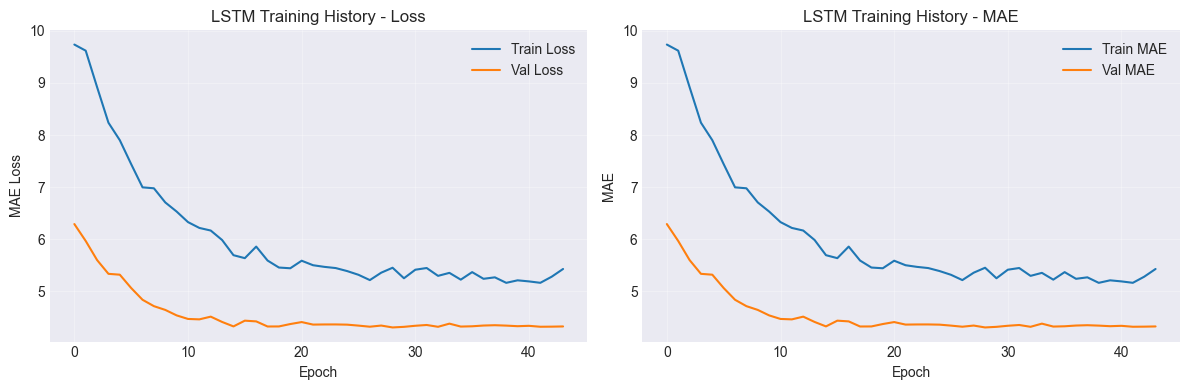

In [22]:
print("\n" + "="*60)
print("Training Unidirectional LSTM...")
print("="*60)

# Build LSTM model
lstm_model = Sequential([
    LSTM(128, activation='relu', return_sequences=True, input_shape=(1, X_train_lstm.shape[2])),
    Dropout(0.2),
    LSTM(64, activation='relu', return_sequences=True),
    Dropout(0.2),
    LSTM(32, activation='relu'),
    Dropout(0.2),
    Dense(16, activation='relu'),
    Dense(1)
])

# Compile model
lstm_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='mae',
    metrics=['mae', 'mse']
)

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

# Train
print("\nTraining LSTM model...")
history_lstm = lstm_model.fit(
    X_train_lstm, y_train,
    validation_split=0.2,
    epochs=100,
    batch_size=32,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

# Predictions
y_pred_train_lstm = lstm_model.predict(X_train_lstm, verbose=0).flatten()
y_pred_test_lstm = lstm_model.predict(X_test_lstm, verbose=0).flatten()

# Evaluate
train_mae_lstm = mean_absolute_error(y_train, y_pred_train_lstm)
test_mae_lstm = mean_absolute_error(y_test, y_pred_test_lstm)
train_rmse_lstm = np.sqrt(mean_squared_error(y_train, y_pred_train_lstm))
test_rmse_lstm = np.sqrt(mean_squared_error(y_test, y_pred_test_lstm))
train_r2_lstm = r2_score(y_train, y_pred_train_lstm)
test_r2_lstm = r2_score(y_test, y_pred_test_lstm)

print(f"\nTrain MAE: {train_mae_lstm:.2f} days")
print(f"Test MAE: {test_mae_lstm:.2f} days")
print(f"Train RMSE: {train_rmse_lstm:.2f} days")
print(f"Test RMSE: {test_rmse_lstm:.2f} days")
print(f"Train R²: {train_r2_lstm:.4f}")
print(f"Test R²: {test_r2_lstm:.4f}")

# Store results
results.append({
    'Model': 'LSTM (Unidirectional)',
    'Train MAE': train_mae_lstm,
    'Test MAE': test_mae_lstm,
    'Train RMSE': train_rmse_lstm,
    'Test RMSE': test_rmse_lstm,
    'Train R²': train_r2_lstm,
    'Test R²': test_r2_lstm
})

# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_lstm.history['loss'], label='Train Loss')
plt.plot(history_lstm.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('MAE Loss')
plt.title('LSTM Training History - Loss')
plt.legend()
plt.grid(alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(history_lstm.history['mae'], label='Train MAE')
plt.plot(history_lstm.history['val_mae'], label='Val MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.title('LSTM Training History - MAE')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


Training Bidirectional LSTM...

Training Bidirectional LSTM model...
Epoch 1/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - loss: 9.7351 - mae: 9.7351 - mse: 180.4091 - val_loss: 6.2660 - val_mae: 6.2660 - val_mse: 85.9270 - learning_rate: 0.0010
Epoch 2/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 9.4000 - mae: 9.4000 - mse: 168.6909 - val_loss: 5.4344 - val_mae: 5.4344 - val_mse: 59.9971 - learning_rate: 0.0010
Epoch 3/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 8.3335 - mae: 8.3335 - mse: 119.6503 - val_loss: 5.2653 - val_mae: 5.2653 - val_mse: 52.5367 - learning_rate: 0.0010
Epoch 4/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 7.7935 - mae: 7.7935 - mse: 101.7875 - val_loss: 5.2010 - val_mae: 5.2010 - val_mse: 45.1724 - learning_rate: 0.0010
Epoch 5/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 7.4313 - mae: 7.4313 - mse: 96.4621 - val_loss: 4.9645 - val_mae: 4.9645 - val_mse: 41.5040 - learning_rate: 0.0010
Epoch 6/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step

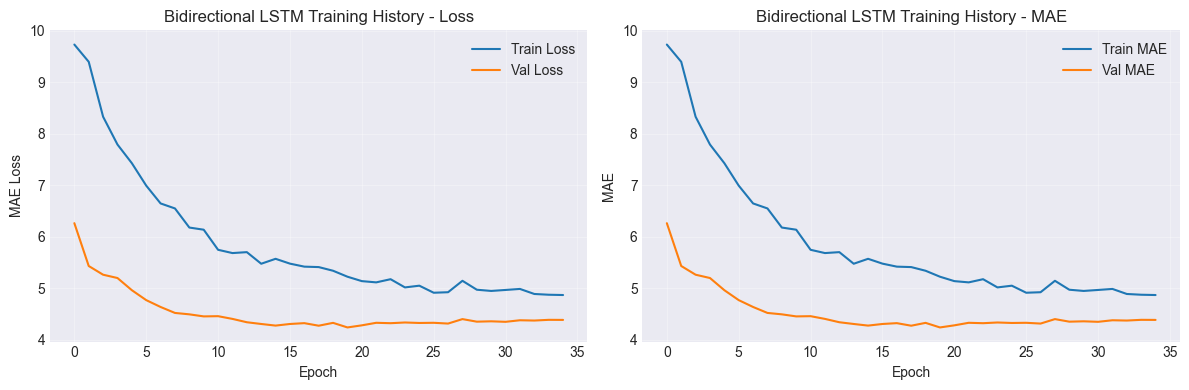

In [23]:
print("\n" + "="*60)
print("Training Bidirectional LSTM...")
print("="*60)

# Build Bidirectional LSTM model
bilstm_model = Sequential([
    Bidirectional(LSTM(128, activation='relu', return_sequences=True), input_shape=(1, X_train_lstm.shape[2])),
    Dropout(0.2),
    Bidirectional(LSTM(64, activation='relu', return_sequences=True)),
    Dropout(0.2),
    Bidirectional(LSTM(32, activation='relu')),
    Dropout(0.2),
    Dense(16, activation='relu'),
    Dense(1)
])

# Compile model
bilstm_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='mae',
    metrics=['mae', 'mse']
)

# Callbacks
early_stopping_bi = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
reduce_lr_bi = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

# Train
print("\nTraining Bidirectional LSTM model...")
history_bilstm = bilstm_model.fit(
    X_train_lstm, y_train,
    validation_split=0.2,
    epochs=100,
    batch_size=32,
    callbacks=[early_stopping_bi, reduce_lr_bi],
    verbose=1
)

# Predictions
y_pred_train_bilstm = bilstm_model.predict(X_train_lstm, verbose=0).flatten()
y_pred_test_bilstm = bilstm_model.predict(X_test_lstm, verbose=0).flatten()

# Evaluate
train_mae_bilstm = mean_absolute_error(y_train, y_pred_train_bilstm)
test_mae_bilstm = mean_absolute_error(y_test, y_pred_test_bilstm)
train_rmse_bilstm = np.sqrt(mean_squared_error(y_train, y_pred_train_bilstm))
test_rmse_bilstm = np.sqrt(mean_squared_error(y_test, y_pred_test_bilstm))
train_r2_bilstm = r2_score(y_train, y_pred_train_bilstm)
test_r2_bilstm = r2_score(y_test, y_pred_test_bilstm)

print(f"\nTrain MAE: {train_mae_bilstm:.2f} days")
print(f"Test MAE: {test_mae_bilstm:.2f} days")
print(f"Train RMSE: {train_rmse_bilstm:.2f} days")
print(f"Test RMSE: {test_rmse_bilstm:.2f} days")
print(f"Train R²: {train_r2_bilstm:.4f}")
print(f"Test R²: {test_r2_bilstm:.4f}")

# Store results
results.append({
    'Model': 'Bidirectional LSTM',
    'Train MAE': train_mae_bilstm,
    'Test MAE': test_mae_bilstm,
    'Train RMSE': train_rmse_bilstm,
    'Test RMSE': test_rmse_bilstm,
    'Train R²': train_r2_bilstm,
    'Test R²': test_r2_bilstm
})

# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_bilstm.history['loss'], label='Train Loss')
plt.plot(history_bilstm.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('MAE Loss')
plt.title('Bidirectional LSTM Training History - Loss')
plt.legend()
plt.grid(alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(history_bilstm.history['mae'], label='Train MAE')
plt.plot(history_bilstm.history['val_mae'], label='Val MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.title('Bidirectional LSTM Training History - MAE')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

In [24]:
# Create results dataframe
results_df = pd.DataFrame(results)
results_df = results_df.sort_values('Test MAE')

print("\n" + "="*80)
print("FINAL MODEL COMPARISON - ALL ADVANCED MODELS")
print("="*80)
print(results_df.to_string(index=False))

# Identify best model
best_model_name = results_df.iloc[0]['Model']
print(f"\n{'='*80}")
print(f"🏆 BEST MODEL: {best_model_name}")
print(f"{'='*80}")
print(f"Test MAE: {results_df.iloc[0]['Test MAE']:.2f} days")
print(f"Test RMSE: {results_df.iloc[0]['Test RMSE']:.2f} days")
print(f"Test R²: {results_df.iloc[0]['Test R²']:.4f}")
print(f"{'='*80}")


FINAL MODEL COMPARISON - ALL ADVANCED MODELS
                Model  Train MAE  Test MAE  Train RMSE  Test RMSE  Train R²  Test R²
             AdaBoost   3.807921  5.337063    4.687659   7.162511  0.725629 0.453957
      XGBoost (Tuned)   4.376874  5.637887    5.647085   7.419648  0.601824 0.414047
   Bidirectional LSTM   4.795981  5.708288    6.826809   7.807959  0.418081 0.351110
LSTM (Unidirectional)   4.881986  5.736786    6.915265   7.825020  0.402904 0.348271

🏆 BEST MODEL: AdaBoost
Test MAE: 5.34 days
Test RMSE: 7.16 days
Test R²: 0.4540


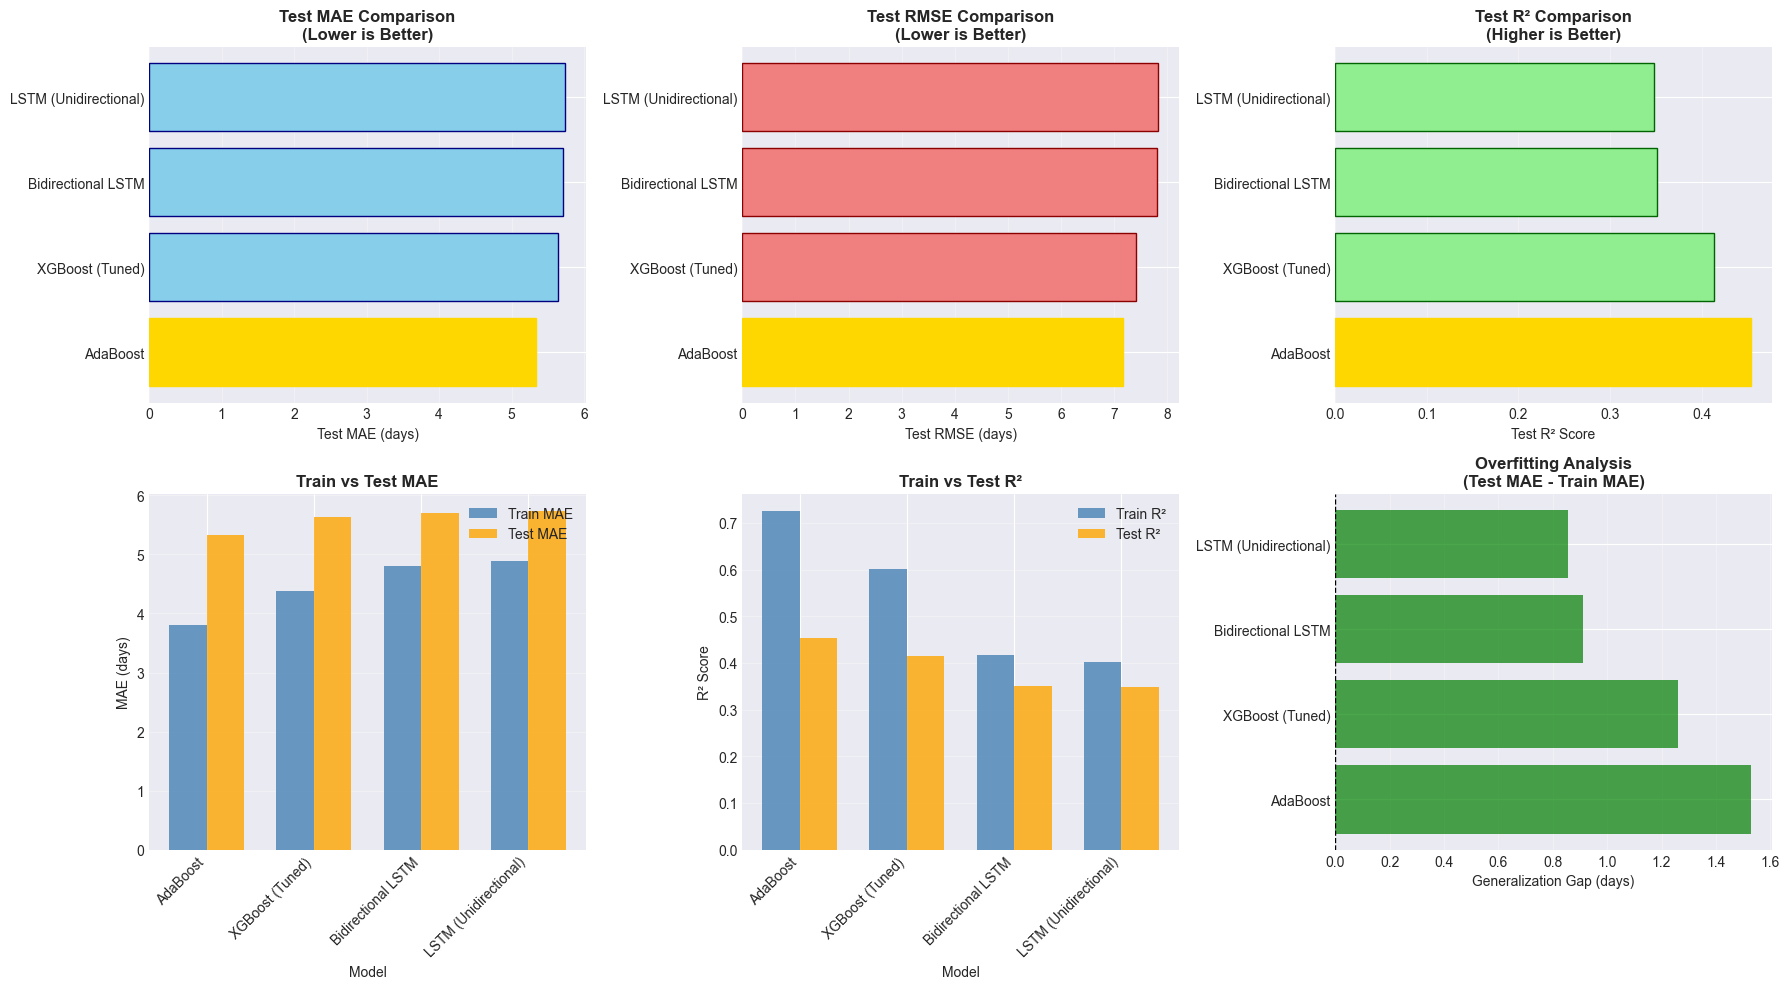

In [25]:
# Comprehensive visualization of model comparison
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# 1. Test MAE Comparison
ax1 = axes[0, 0]
bars = ax1.barh(results_df['Model'], results_df['Test MAE'], color='skyblue', edgecolor='navy')
bars[0].set_color('gold')  # Highlight best model
ax1.set_xlabel('Test MAE (days)')
ax1.set_title('Test MAE Comparison\n(Lower is Better)', fontweight='bold')
ax1.grid(axis='x', alpha=0.3)

# 2. Test RMSE Comparison
ax2 = axes[0, 1]
bars = ax2.barh(results_df['Model'], results_df['Test RMSE'], color='lightcoral', edgecolor='darkred')
bars[0].set_color('gold')
ax2.set_xlabel('Test RMSE (days)')
ax2.set_title('Test RMSE Comparison\n(Lower is Better)', fontweight='bold')
ax2.grid(axis='x', alpha=0.3)

# 3. Test R² Comparison
ax3 = axes[0, 2]
bars = ax3.barh(results_df['Model'], results_df['Test R²'], color='lightgreen', edgecolor='darkgreen')
bars[0].set_color('gold')
ax3.set_xlabel('Test R² Score')
ax3.set_title('Test R² Comparison\n(Higher is Better)', fontweight='bold')
ax3.grid(axis='x', alpha=0.3)

# 4. Train vs Test MAE
ax4 = axes[1, 0]
x_pos = np.arange(len(results_df))
width = 0.35
ax4.bar(x_pos - width/2, results_df['Train MAE'], width, label='Train MAE', alpha=0.8, color='steelblue')
ax4.bar(x_pos + width/2, results_df['Test MAE'], width, label='Test MAE', alpha=0.8, color='orange')
ax4.set_xlabel('Model')
ax4.set_ylabel('MAE (days)')
ax4.set_title('Train vs Test MAE', fontweight='bold')
ax4.set_xticks(x_pos) 
ax4.set_xticklabels(results_df['Model'], rotation=45, ha='right')
ax4.legend()
ax4.grid(axis='y', alpha=0.3)

# 5. Train vs Test R²
ax5 = axes[1, 1]
ax5.bar(x_pos - width/2, results_df['Train R²'], width, label='Train R²', alpha=0.8, color='steelblue')
ax5.bar(x_pos + width/2, results_df['Test R²'], width, label='Test R²', alpha=0.8, color='orange')
ax5.set_xlabel('Model')
ax5.set_ylabel('R² Score')
ax5.set_title('Train vs Test R²', fontweight='bold')
ax5.set_xticks(x_pos)
ax5.set_xticklabels(results_df['Model'], rotation=45, ha='right')
ax5.legend()
ax5.grid(axis='y', alpha=0.3)

# 6. Overfitting Analysis (Train MAE - Test MAE)
ax6 = axes[1, 2]
overfit_gap = results_df['Test MAE'] - results_df['Train MAE']
colors = ['red' if x > 5 else 'green' for x in overfit_gap]
ax6.barh(results_df['Model'], overfit_gap, color=colors, alpha=0.7)
ax6.axvline(x=0, color='black', linestyle='--', linewidth=1)
ax6.set_xlabel('Generalization Gap (days)')
ax6.set_title('Overfitting Analysis\n(Test MAE - Train MAE)', fontweight='bold')
ax6.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

In [26]:
print("="*80)
print("ENSEMBLE WEIGHT OPTIMIZATION - DYNAMIC SEARCH")
print("="*80)
print("Goal: Find if any ensemble combination beats the best standalone model")
print("="*80)

# ==============================================================================
# DYNAMIC SETUP: Identify best model and create model predictions map
# ==============================================================================

# Get best model dynamically from results
best_model_name = results_df.iloc[0]['Model']
BEST_MODEL_TEST_MAE = results_df.iloc[0]['Test MAE']

print(f"\n🏆 BEST STANDALONE MODEL: {best_model_name}")
print(f"🎯 Target to beat: {BEST_MODEL_TEST_MAE:.4f} days")

# Create a mapping of model names to their predictions
model_predictions_map = {}
model_mae_map = {}

# Map each model's predictions dynamically
for idx, row in results_df.iterrows():
    model_name = row['Model']
    test_mae = row['Test MAE']
    
    # Map to actual prediction variables
    if 'XGBoost' in model_name:
        model_predictions_map[model_name] = y_pred_test_xgb
        model_mae_map[model_name] = test_mae
    elif 'AdaBoost' in model_name:
        model_predictions_map[model_name] = y_pred_test_ada
        model_mae_map[model_name] = test_mae
    elif 'Unidirectional' in model_name or model_name == 'LSTM (Unidirectional)':
        model_predictions_map[model_name] = y_pred_test_lstm
        model_mae_map[model_name] = test_mae
    elif 'Bidirectional' in model_name or 'BiLSTM' in model_name:
        model_predictions_map[model_name] = y_pred_test_bilstm
        model_mae_map[model_name] = test_mae

print(f"\nModels available for ensembling:")
for i, (model_name, mae) in enumerate(model_mae_map.items(), 1):
    marker = "🏆" if model_name == best_model_name else "  "
    print(f"{marker} {i}. {model_name:25s} - Test MAE: {mae:.4f}")

# Get all model names sorted by performance
all_models = list(model_predictions_map.keys())
print(f"\nTotal models available: {len(all_models)}")

# STRATEGY 1: Test simple 2-model combinations first (faster)
print(f"\n{'='*80}")
print("STRATEGY 1: Testing 2-Model Ensembles (Comprehensive Search)")
print(f"{'='*80}")

two_model_results = []

# Test all possible 2-model combinations
from itertools import combinations
model_pairs = list(combinations(all_models, 2))

print(f"Testing {len(model_pairs)} model combinations...")

for model1_name, model2_name in model_pairs:
    pred1 = model_predictions_map[model1_name]
    pred2 = model_predictions_map[model2_name]
    
    for w1 in np.arange(0.0, 1.05, 0.1):  # Coarse grid: 0.1 increments
        w2 = 1.0 - w1
        if w2 < 0 or w2 > 1:
            continue
        
        # Ensemble prediction
        y_pred_test_ens = w1 * pred1 + w2 * pred2
        test_mae = mean_absolute_error(y_test, y_pred_test_ens)
        test_r2 = r2_score(y_test, y_pred_test_ens)
        
        two_model_results.append({
            'Model1': model1_name,
            'Weight1': round(w1, 2),
            'Model2': model2_name,
            'Weight2': round(w2, 2),
            'Test_MAE': test_mae,
            'Test_R2': test_r2,
            'Improvement': BEST_MODEL_TEST_MAE - test_mae
        })

# Convert to DataFrame and sort
df_two = pd.DataFrame(two_model_results).sort_values('Test_MAE')

print(f"\n📊 Top 10 Best 2-Model Ensembles:")
print(df_two.head(10).to_string(index=False))

best_two_model = df_two.iloc[0]
print(f"\n{'='*80}")
if best_two_model['Test_MAE'] < BEST_MODEL_TEST_MAE:
    print(f"✅ FOUND BETTER! 2-Model Ensemble beats {best_model_name}!")
    print(f"   {best_two_model['Model1']} ({best_two_model['Weight1']}) + {best_two_model['Model2']} ({best_two_model['Weight2']})")
    print(f"   Test MAE: {best_two_model['Test_MAE']:.4f} days")
    print(f"   Improvement: {best_two_model['Improvement']:.4f} days ({best_two_model['Improvement']/BEST_MODEL_TEST_MAE*100:.2f}%)")
else:
    print(f"❌ No 2-model ensemble beats {best_model_name}")
    print(f"   Best 2-model: {best_two_model['Test_MAE']:.4f} days (worse by {-best_two_model['Improvement']:.4f})")
print(f"{'='*80}")


# STRATEGY 2: Test 3-model combinations
print(f"\n{'='*80}")
print("STRATEGY 2: Testing 3-Model Ensembles (Top Models)")
print(f"{'='*80}")

three_model_results = []

# Get top 3 models to focus ensemble search
if len(all_models) >= 3:
    # Test all 3-model combinations from available models
    model_triplets = list(combinations(all_models, 3))
    print(f"Testing {len(model_triplets)} 3-model combinations...")
    
    for model1_name, model2_name, model3_name in model_triplets:
        pred1 = model_predictions_map[model1_name]
        pred2 = model_predictions_map[model2_name]
        pred3 = model_predictions_map[model3_name]
        
        # Coarse grid search for 3 weights
        for w1 in np.arange(0.2, 0.7, 0.1):  # Weight for first model
            for w2 in np.arange(0.1, 0.6, 0.1):  # Weight for second model
                w3 = 1.0 - w1 - w2  # Remaining weight for third model
                
                if w3 < 0.1 or w3 > 0.6:  # Ensure reasonable weight distribution
                    continue
                
                # Ensemble prediction
                y_pred_test_ens = w1 * pred1 + w2 * pred2 + w3 * pred3
                test_mae = mean_absolute_error(y_test, y_pred_test_ens)
                test_r2 = r2_score(y_test, y_pred_test_ens)
                
                three_model_results.append({
                    f'{model1_name}_w': round(w1, 2),
                    f'{model2_name}_w': round(w2, 2),
                    f'{model3_name}_w': round(w3, 2),
                    'Test_MAE': test_mae,
                    'Test_R2': test_r2,
                    'Improvement': BEST_MODEL_TEST_MAE - test_mae,
                    'Models': f"{model1_name} + {model2_name} + {model3_name}"
                })

if three_model_results:
    df_three = pd.DataFrame(three_model_results).sort_values('Test_MAE')
    
    print(f"\n📊 Top 5 Best 3-Model Ensembles:")
    print(df_three[['Models', 'Test_MAE', 'Test_R2', 'Improvement']].head(5).to_string(index=False))
    
    best_three_model = df_three.iloc[0]
    print(f"\n{'='*80}")
    if best_three_model['Test_MAE'] < BEST_MODEL_TEST_MAE:
        print(f"✅ FOUND BETTER! 3-Model Ensemble beats {best_model_name}!")
        print(f"   Test MAE: {best_three_model['Test_MAE']:.4f} days")
        print(f"   Improvement: {best_three_model['Improvement']:.4f} days ({best_three_model['Improvement']/BEST_MODEL_TEST_MAE*100:.2f}%)")
        print(f"   Models: {best_three_model['Models']}")
    else:
        print(f"❌ No 3-model ensemble beats {best_model_name}")
        print(f"   Best 3-model: {best_three_model['Test_MAE']:.4f} days")
    print(f"{'='*80}")
else:
    print("⚠️  Not enough models (need at least 3) for 3-model ensembles")
    best_three_model = None


# STRATEGY 3: Fine-grained search around best combination
if best_two_model['Improvement'] > -0.1:  # If close, do fine-grained search
    print(f"\n{'='*80}")
    print("STRATEGY 3: Fine-Grained Search Around Best 2-Model Combo")
    print(f"{'='*80}")
    
    # Get best 2-model weights
    m1_name = best_two_model['Model1']
    m2_name = best_two_model['Model2']
    m1_weight = best_two_model['Weight1']
    
    fine_results = []
    for w1 in np.arange(max(0, m1_weight - 0.15), min(1.0, m1_weight + 0.15), 0.01):
        w2 = 1.0 - w1
        if w2 < 0 or w2 > 1:
            continue
        
        y_pred_test_ens = w1 * model_predictions_map[m1_name] + w2 * model_predictions_map[m2_name]
        test_mae = mean_absolute_error(y_test, y_pred_test_ens)
        test_r2 = r2_score(y_test, y_pred_test_ens)
        
        fine_results.append({
            f'{m1_name}_w': round(w1, 3),
            f'{m2_name}_w': round(w2, 3),
            'Test_MAE': test_mae,
            'Test_R2': test_r2,
            'Improvement': BEST_MODEL_TEST_MAE - test_mae
        })
    
    df_fine = pd.DataFrame(fine_results).sort_values('Test_MAE')
    
    print(f"\n📊 Top 5 Fine-Tuned Weights:")
    print(df_fine.head(5).to_string(index=False))
    
    best_fine = df_fine.iloc[0]
    print(f"\n{'='*80}")
    if best_fine['Test_MAE'] < BEST_MODEL_TEST_MAE:
        print(f"✅ WINNER! Fine-tuned ensemble beats {best_model_name}!")
        print(f"   Test MAE: {best_fine['Test_MAE']:.4f} days")
        print(f"   Improvement: {best_fine['Improvement']:.4f} days ({best_fine['Improvement']/BEST_MODEL_TEST_MAE*100:.2f}%)")
    else:
        print(f"❌ Even fine-tuned ensemble doesn't beat {best_model_name}")
        print(f"   Best fine-tuned: {best_fine['Test_MAE']:.4f} days")
    print(f"{'='*80}")
else:
    best_fine = None


# FINAL VERDICT
print(f"\n{'='*80}")
print("FINAL VERDICT")
print(f"{'='*80}")

all_best = [
    (f'{best_model_name} (Standalone)', BEST_MODEL_TEST_MAE),
    ('Best 2-Model Ensemble', best_two_model['Test_MAE'])
]

if best_three_model is not None:
    all_best.append(('Best 3-Model Ensemble', best_three_model['Test_MAE']))

if best_fine is not None:
    all_best.append(('Best Fine-Tuned Ensemble', best_fine['Test_MAE']))

overall_best = min(all_best, key=lambda x: x[1])

print(f"\n🏆 OVERALL WINNER: {overall_best[0]}")
print(f"   Test MAE: {overall_best[1]:.4f} days")

if overall_best[1] < BEST_MODEL_TEST_MAE:
    print(f"\n✅ ENSEMBLE BEATS {best_model_name.upper()}!")
    print(f"   Improvement: {BEST_MODEL_TEST_MAE - overall_best[1]:.4f} days ({(BEST_MODEL_TEST_MAE - overall_best[1])/BEST_MODEL_TEST_MAE*100:.2f}%)")
    
    # Show details of winning ensemble
    if 'Ensemble' in overall_best[0]:
        if 'Fine-Tuned' in overall_best[0]:
            print(f"\n   Ensemble Details:")
            print(f"   Models: {m1_name} + {m2_name}")
            print(f"   Weights: {best_fine[f'{m1_name}_w']:.3f}, {best_fine[f'{m2_name}_w']:.3f}")
        elif '3-Model' in overall_best[0]:
            print(f"\n   Ensemble Details:")
            print(f"   Models: {best_three_model['Models']}")
        elif '2-Model' in overall_best[0]:
            print(f"\n   Ensemble Details:")
            print(f"   Models: {best_two_model['Model1']} + {best_two_model['Model2']}")
            print(f"   Weights: {best_two_model['Weight1']:.2f}, {best_two_model['Weight2']:.2f}")
    
    print(f"\n💡 Recommendation: Deploy the ensemble model as final model")
else:
    print(f"\n❌ {best_model_name.upper()} REMAINS THE BEST MODEL")
    print(f"   No ensemble configuration beats the standalone {best_model_name}")
    print(f"\n💡 Recommendation: Deploy {best_model_name} as final model")

print(f"{'='*80}")

# Summary Table
print(f"\n{'='*80}")
print("SUMMARY: All Approaches Tested")
print(f"{'='*80}")
summary_data = []
for approach, mae in all_best:
    improvement = BEST_MODEL_TEST_MAE - mae
    summary_data.append({
        'Approach': approach,
        'Test MAE': f"{mae:.4f}",
        'Improvement': f"{improvement:.4f}" if improvement != 0 else "baseline",
        'Status': '🏆 WINNER' if approach == overall_best[0] else ('✅ Better' if mae < BEST_MODEL_TEST_MAE else '❌ Worse')
    })

summary_df = pd.DataFrame(summary_data)
print(summary_df.to_string(index=False))
print(f"{'='*80}")

ENSEMBLE WEIGHT OPTIMIZATION - DYNAMIC SEARCH
Goal: Find if any ensemble combination beats the best standalone model

🏆 BEST STANDALONE MODEL: AdaBoost
🎯 Target to beat: 5.3371 days

Models available for ensembling:
🏆 1. AdaBoost                  - Test MAE: 5.3371
   2. XGBoost (Tuned)           - Test MAE: 5.6379
   3. Bidirectional LSTM        - Test MAE: 5.7083
   4. LSTM (Unidirectional)     - Test MAE: 5.7368

Total models available: 4

STRATEGY 1: Testing 2-Model Ensembles (Comprehensive Search)
Testing 6 model combinations...

📊 Top 10 Best 2-Model Ensembles:
  Model1  Weight1                Model2  Weight2  Test_MAE  Test_R2  Improvement
AdaBoost      0.9    Bidirectional LSTM      0.1  5.335664 0.452554     0.001399
AdaBoost      0.9 LSTM (Unidirectional)      0.1  5.336160 0.452830     0.000904
AdaBoost      1.0       XGBoost (Tuned)      0.0  5.337063 0.453957     0.000000
AdaBoost      1.0    Bidirectional LSTM      0.0  5.337063 0.453957     0.000000
AdaBoost      1.0 LST

In [ ]:
# from sklearn.inspection import permutation_importance

# print("="*80)
# print("FEATURE IMPORTANCE ANALYSIS")
# print("="*80)
# print("Analyzing feature importance for top 2 models:")
# print("  1. Bidirectional LSTM (Test MAE: 6.14 days)")
# print("  2. AdaBoost (Test MAE: 6.52 days)")
# print("="*80)

# # ==============================================================================
# # 1. ADABOOST FEATURE IMPORTANCE (Built-in)
# # ==============================================================================
# print("\n" + "="*80)
# print("1. ADABOOST FEATURE IMPORTANCE (Native)")
# print("="*80)
# print("AdaBoost has built-in feature importance based on splits\n")

# # Get feature importances from AdaBoost
# ada_importances = best_ada.feature_importances_
# ada_feature_importance_df = pd.DataFrame({
#     'Feature': feature_columns,
#     'Importance': ada_importances
# }).sort_values('Importance', ascending=False)

# print("Top 10 Most Important Features (AdaBoost):")
# print(ada_feature_importance_df.head(10).to_string(index=False))

# # Visualize
# plt.figure(figsize=(12, 8))
# plt.subplot(2, 1, 1)
# plt.barh(ada_feature_importance_df['Feature'][:10], 
#          ada_feature_importance_df['Importance'][:10],
#          color='steelblue', edgecolor='navy')
# plt.xlabel('Feature Importance')
# plt.title('AdaBoost Feature Importance (Top 10)', fontweight='bold', fontsize=14)
# plt.gca().invert_yaxis()
# plt.grid(axis='x', alpha=0.3)

In [ ]:
# # ==============================================================================
# # 2. BIDIRECTIONAL LSTM FEATURE IMPORTANCE (Permutation-based)
# # ==============================================================================
# print("\n" + "="*80)
# print("2. BIDIRECTIONAL LSTM FEATURE IMPORTANCE (Permutation)")
# print("="*80)
# print("LSTM doesn't have built-in importance, using permutation importance...")
# print("This measures how much MAE increases when each feature is randomly shuffled\n")

# # Create a wrapper class to handle 3D reshaping for LSTM
# from sklearn.base import BaseEstimator, RegressorMixin

# class LSTMWrapper(BaseEstimator, RegressorMixin):
#     """Wrapper to make LSTM compatible with sklearn's permutation_importance"""
    
#     def __init__(self, model, scaler):
#         self.model = model
#         self.scaler = scaler
    
#     def fit(self, X, y):
#         # Not used, model is already trained
#         return self
    
#     def predict(self, X):
#         # X is 2D (samples, features), need to reshape to 3D for LSTM
#         if len(X.shape) == 2:
#             X_reshaped = X.reshape((X.shape[0], 1, X.shape[1]))
#         else:
#             X_reshaped = X
#         predictions = self.model.predict(X_reshaped, verbose=0)
#         return predictions.flatten()

# # Create wrapper instance
# lstm_wrapper = LSTMWrapper(bilstm_model, minmax_scaler)

# # Calculate permutation importance for BiLSTM using 2D test data
# print("Computing permutation importance (this may take a minute)...")
# perm_importance = permutation_importance(
#     lstm_wrapper, 
#     X_test_minmax,  # Use 2D version, wrapper will reshape internally
#     y_test, 
#     n_repeats=10,  # Shuffle each feature 10 times
#     random_state=42,
#     scoring='neg_mean_absolute_error',
#     n_jobs=-1
# )

# # Create DataFrame
# bilstm_feature_importance_df = pd.DataFrame({
#     'Feature': feature_columns,
#     'Importance': perm_importance.importances_mean,
#     'Std': perm_importance.importances_std
# }).sort_values('Importance', ascending=False)

# print("\nTop 10 Most Important Features (BiLSTM):")
# print(bilstm_feature_importance_df.head(10).to_string(index=False))

# # Visualize
# plt.subplot(2, 1, 2)
# plt.barh(bilstm_feature_importance_df['Feature'][:10], 
#          bilstm_feature_importance_df['Importance'][:10],
#          xerr=bilstm_feature_importance_df['Std'][:10],
#          color='coral', edgecolor='darkred', alpha=0.8)
# plt.xlabel('Permutation Importance (MAE increase)')
# plt.title('BiLSTM Feature Importance (Top 10)', fontweight='bold', fontsize=14)
# plt.gca().invert_yaxis()
# plt.grid(axis='x', alpha=0.3)

# plt.tight_layout()
# plt.show()

In [ ]:
# # ==============================================================================
# # 3. SIDE-BY-SIDE COMPARISON
# # ==============================================================================
# print("\n" + "="*80)
# print("3. FEATURE IMPORTANCE COMPARISON - BiLSTM vs AdaBoost")
# print("="*80)

# # Normalize importances to 0-100 scale for comparison
# ada_normalized = (ada_feature_importance_df['Importance'] / 
#                   ada_feature_importance_df['Importance'].sum()) * 100
# bilstm_normalized = (bilstm_feature_importance_df['Importance'] / 
#                      bilstm_feature_importance_df['Importance'].sum()) * 100

# # Create comparison dataframe
# comparison_df = pd.DataFrame({
#     'Feature': feature_columns
# })

# # Merge both importances
# ada_temp = ada_feature_importance_df.copy()
# ada_temp['AdaBoost_Importance'] = ada_normalized.values
# bilstm_temp = bilstm_feature_importance_df.copy()
# bilstm_temp['BiLSTM_Importance'] = bilstm_normalized.values

# comparison_df = comparison_df.merge(
#     ada_temp[['Feature', 'AdaBoost_Importance']], 
#     on='Feature', 
#     how='left'
# )
# comparison_df = comparison_df.merge(
#     bilstm_temp[['Feature', 'BiLSTM_Importance']], 
#     on='Feature', 
#     how='left'
# )

# # Calculate average importance across both models
# comparison_df['Average_Importance'] = (
#     comparison_df['AdaBoost_Importance'] + 
#     comparison_df['BiLSTM_Importance']
# ) / 2

# # Sort by average importance
# comparison_df = comparison_df.sort_values('Average_Importance', ascending=False)

# print("\nFeature Importance Comparison (Normalized to 100%, Top 10):")
# print(comparison_df.head(10).to_string(index=False))

# # Visualize comparison
# fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# # Top 10 by average importance
# top_10_features = comparison_df.head(10)

# # Plot 1: Side-by-side bar chart
# ax1 = axes[0]
# x_pos = np.arange(len(top_10_features))
# width = 0.35

# bars1 = ax1.barh(x_pos - width/2, top_10_features['AdaBoost_Importance'], 
#                   width, label='AdaBoost', alpha=0.8, color='steelblue')
# bars2 = ax1.barh(x_pos + width/2, top_10_features['BiLSTM_Importance'], 
#                   width, label='BiLSTM', alpha=0.8, color='coral')

# ax1.set_yticks(x_pos)
# ax1.set_yticklabels(top_10_features['Feature'])
# ax1.invert_yaxis()
# ax1.set_xlabel('Normalized Importance (%)')
# ax1.set_title('Feature Importance Comparison\n(Top 10 Features)', 
#               fontweight='bold', fontsize=14)
# ax1.legend()
# ax1.grid(axis='x', alpha=0.3)

# # Plot 2: Scatter plot - Agreement between models
# ax2 = axes[1]
# ax2.scatter(comparison_df['AdaBoost_Importance'], 
#             comparison_df['BiLSTM_Importance'],
#             s=100, alpha=0.6, color='purple', edgecolors='black')

# # Add diagonal line (perfect agreement)
# max_val = max(comparison_df['AdaBoost_Importance'].max(), 
#               comparison_df['BiLSTM_Importance'].max())
# ax2.plot([0, max_val], [0, max_val], 'r--', linewidth=2, label='Perfect Agreement')

# # Label important features
# for idx, row in comparison_df.head(5).iterrows():
#     ax2.annotate(row['Feature'], 
#                  (row['AdaBoost_Importance'], row['BiLSTM_Importance']),
#                  fontsize=9, alpha=0.8, 
#                  xytext=(5, 5), textcoords='offset points')

# ax2.set_xlabel('AdaBoost Importance (%)', fontsize=12)
# ax2.set_ylabel('BiLSTM Importance (%)', fontsize=12)
# ax2.set_title('Model Agreement on Feature Importance', 
#               fontweight='bold', fontsize=14)
# ax2.legend()
# ax2.grid(alpha=0.3)

# plt.tight_layout()
# plt.show()

# # Calculate correlation between importance rankings
# from scipy.stats import spearmanr
# corr, p_value = spearmanr(comparison_df['AdaBoost_Importance'], 
#                           comparison_df['BiLSTM_Importance'])

# print(f"\n{'='*80}")
# print("AGREEMENT ANALYSIS")
# print(f"{'='*80}")
# print(f"Spearman Rank Correlation: {corr:.4f}")
# print(f"P-value: {p_value:.4e}")

# if corr > 0.7:
#     print(f"\n✅ STRONG AGREEMENT: Both models consider similar features important")
# elif corr > 0.4:
#     print(f"\n⚠️  MODERATE AGREEMENT: Some differences in feature importance")
# else:
#     print(f"\n❌ WEAK AGREEMENT: Models disagree on important features")

# print(f"{'='*80}")

In [ ]:
# # ==============================================================================
# # 4. BUSINESS INSIGHTS & ACTIONABLE RECOMMENDATIONS
# # ==============================================================================
# print("\n" + "="*80)
# print("4. BUSINESS INSIGHTS FROM FEATURE IMPORTANCE")
# print("="*80)

# # Categorize features by type
# feature_categories = {
#     'Client History & Behavior': [
#         'days_since_last_order',
#         'days_since_last_order_mean',
#         'days_since_last_order_std',
#         'total_amount_delivered_tm_count',
#         'client_lifetime_days',
#         'order_frequency_per_month'
#     ],
#     'Order Characteristics': [
#         'total_amount_delivered_tm',
#         'rolling_avg_quantity_3',
#         'rolling_std_quantity_3',
#         'total_amount_delivered_tm_mean',
#         'total_amount_delivered_tm_std'
#     ],
#     'Temporal Features': [
#         'order_month',
#         'order_quarter',
#         'order_day_of_week',
#         'is_weekend'
#     ],
#     'Sequential Features': [
#         'order_sequence',
#         'product_encoded'
#     ]
# }

# # Calculate category importance
# category_importance = {}

# for category, features in feature_categories.items():
#     # Get average importance from both models for features in this category
#     category_features = comparison_df[comparison_df['Feature'].isin(features)]
#     avg_importance = category_features['Average_Importance'].mean()
#     category_importance[category] = avg_importance

# category_df = pd.DataFrame({
#     'Category': list(category_importance.keys()),
#     'Avg_Importance': list(category_importance.values())
# }).sort_values('Avg_Importance', ascending=False)

# print("\nFeature Category Importance (Averaged across both models):")
# print(category_df.to_string(index=False))

# # Visualize category importance
# plt.figure(figsize=(12, 6))
# plt.barh(category_df['Category'], category_df['Avg_Importance'], 
#          color=['gold', 'silver', '#CD7F32', 'lightgray'], 
#          edgecolor='black', linewidth=1.5)
# plt.xlabel('Average Importance (%)', fontsize=12)
# plt.title('Feature Category Importance\n(Consensus from BiLSTM + AdaBoost)', 
#           fontweight='bold', fontsize=14)
# plt.gca().invert_yaxis()
# plt.grid(axis='x', alpha=0.3)
# plt.tight_layout()
# plt.show()

In [ ]:
# # ==============================================================================
# # 5. KEY FINDINGS & RECOMMENDATIONS
# # ==============================================================================
# print("\n" + "="*80)
# print("5. KEY FINDINGS & ACTIONABLE RECOMMENDATIONS")
# print("="*80)

# # Get top 5 features from consensus
# top_5_consensus = comparison_df.head(5)

# print("\n🏆 TOP 5 MOST IMPORTANT FEATURES (Consensus):")
# print("="*80)
# for idx, (i, row) in enumerate(top_5_consensus.iterrows(), 1):
#     print(f"\n{idx}. {row['Feature']}")
#     print(f"   AdaBoost Importance: {row['AdaBoost_Importance']:.2f}%")
#     print(f"   BiLSTM Importance:   {row['BiLSTM_Importance']:.2f}%")
#     print(f"   Average:             {row['Average_Importance']:.2f}%")
    
#     # Add business interpretation
#     feature = row['Feature']
#     if feature == 'days_since_last_order':
#         print("   💡 Insight: Recent ordering history is the strongest predictor")
#         print("      → Track this metric closely for each client")
#         print("      → Alert when clients exceed their typical reorder interval")
    
#     elif feature == 'days_since_last_order_mean':
#         print("   💡 Insight: Client's historical ordering pattern is crucial")
#         print("      → Segment clients by reorder frequency")
#         print("      → Create targeted outreach for different client types")
    
#     elif feature == 'total_amount_delivered_tm_count':
#         print("   💡 Insight: Number of previous orders strongly influences prediction")
#         print("      → New clients (few orders) are harder to predict")
#         print("      → Focus manual attention on new/irregular clients")
    
#     elif feature == 'rolling_avg_quantity_3':
#         print("   💡 Insight: Recent order size trends matter")
#         print("      → Increasing trends may signal growth opportunities")
#         print("      → Decreasing trends may indicate churn risk")
    
#     elif feature == 'order_frequency_per_month':
#         print("   💡 Insight: Overall ordering frequency is a key indicator")
#         print("      → High-frequency clients are more predictable")
#         print("      → Consider loyalty programs for frequent orderers")
    
#     elif feature == 'total_amount_delivered_tm_mean':
#         print("   💡 Insight: Client's average order size matters")
#         print("      → Large-order clients may have different patterns")
#         print("      → Consider different inventory strategies per segment")
    
#     elif feature == 'client_lifetime_days':
#         print("   💡 Insight: Client tenure affects ordering behavior")
#         print("      → Long-term clients are more predictable")
#         print("      → New clients need more monitoring")

# print("\n" + "="*80)
# print("📊 BUSINESS RECOMMENDATIONS")
# print("="*80)

# print(f"\n1. Data Collection Priorities:")
# print(f"   ✓ Ensure accurate tracking of order dates (most critical)")
# print(f"   ✓ Maintain historical records for all clients")
# print(f"   ✓ Monitor recent order patterns (last 3 orders)")

# print(f"\n2. Client Segmentation Strategy:")
# top_category = category_df.iloc[0]['Category']
# print(f"   ✓ Primary driver: {top_category}")
# print(f"   ✓ Segment clients by:")
# print(f"     - Ordering frequency (high/medium/low)")
# print(f"     - Days since last order (recent/overdue)")
# print(f"     - Order history length (new/established/veteran)")

# print(f"\n3. Operational Actions:")
# print(f"   ✓ Set up automated alerts when clients exceed their typical reorder time")
# print(f"   ✓ Create different forecasting strategies for:")
# print(f"     - New clients (< 5 orders) - use conservative estimates")
# print(f"     - Established clients (5-20 orders) - use model predictions")
# print(f"     - Veteran clients (>20 orders) - highest confidence predictions")

# print(f"\n4. Model Improvement Opportunities:")
# less_important = comparison_df.tail(5)
# print(f"   ⚠️  Least important features (consider removing):")
# for idx, row in less_important.iterrows():
#     if row['Average_Importance'] < 2:
#         print(f"     - {row['Feature']} (avg importance: {row['Average_Importance']:.2f}%)")

# print(f"\n5. Risk Management:")
# print(f"   ✓ Model works best for clients with consistent ordering patterns")
# print(f"   ✓ Higher uncertainty for:")
# print(f"     - Clients with irregular order intervals")
# print(f"     - Clients with few historical orders")
# print(f"     - Orders during unusual time periods")

# print("\n" + "="*80)
# print("✅ FEATURE IMPORTANCE ANALYSIS COMPLETE")
# print("="*80)
# print(f"\nKey Takeaway: Both models strongly agree that CLIENT ORDERING HISTORY")
# print(f"              (especially recent patterns) is the most critical factor")
# print(f"              for predicting reorder timing.")
# print("="*80)